# Linear Regssion Take 2:
<pre>
Name: Prarthana Rao
Andrew: pprao
</pre>

So far we have studied the basic idea behind linear regression and OLS along with some regularization techniques. 

This notebook is aimed to be an experiment undersanding the very basics of uncomplicating your model, three types of regressions and when which performs better.


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model as lr
import numpy as np
import seaborn as sn
import time
from sklearn.model_selection import cross_val_score

%matplotlib inline

# Predicting Coronary Heart Disease

For the purposes of this regression , let us now see if we can predict age at onset of coronary heart disease in males in a heart-disease high-risk region of the Western Cape, South Africa. The background of this data set was obtained from http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/SAheart. The description is mentioed below

"There are roughly two controls per case of CHD. Many of the CHD positive men have undergone blood pressure reduction treatment and other programs to reduce their risk factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger dataset, described in  Rousseauw et al, 1983, South African Medical."

The description of the data can be found at http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/SAheart.info.txt, whose contents are below:



<table>
    <tr>
        <td><b>Feature</b></td>
        <td><b>Interpretation</b></td>
    </tr>
    <tr>
        <td>sbp</td>
        <td>systolic blood pressure</td>
    </tr>
    <tr>
        <td>tobacco</td>
        <td>cumulative tobacco (kg)</td>
    </tr>
    <tr>
        <td>ldl</td>
        <td>low densiity lipoprotein cholesterol</td>
    </tr>
    <tr>
        <td>adiposity</td>
        <td>adiposity</td>
    </tr>
    <tr>
        <td>famhist</td>
        <td>family history of heart disease</td>
    </tr>
     <tr>
        <td>typea</td>
        <td>type-A behavior</td>
    </tr>
    <tr>
        <td>obesity</td>
        <td>obesity</td>
    </tr>
    <tr>
        <td>alcohol</td>
        <td>current alcohol consumption</td>
    </tr>
     <tr>
        <td>age</td>
        <td>age at onset</td>
    </tr>
    <tr>
        <td>chd</td>
        <td>response, coronary heart disease</td>
    </tr>
    
</table>



In [22]:
#Let us begin by reading the data
df = pd.read_csv('http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/SAheart.data', index_col=0)
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [23]:
#To understand what we are dealing with let us see some basic summary statistics of our data the reason we do this
# is to get a brief idea of what the data looks like 
df.describe()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


# Feature treatment
In this segment we will be perform two tasks:

<ol>
<li>
As we can see, famhist is a categorial variable that can take on two values Present or Absent. Since we cannot directly feed this into our regression model let us binarize.
</li>
<li>
 Creating a new variable called weight variable to simulate a potential feature that may have been given in the dataset.</li>
</ol>


In [24]:
#binarizing data
df =  pd.get_dummies(df, prefix=['famhist'])
#since famhist_Absent and famhist_Present essentially carry the same information, we need only one of these variables
df.pop('famhist_Present')
#create a new variable called weight and add it to the df. The reason we are doing this is to illustrate an example
#later during the notebook
noise = np.random.randn(len(df.age))     
weight = df.obesity * 2.5 + (0.5 * noise).astype(int)
df['weight'] = weight

# Multicolinearity
We already know that usually complex models take longer to run. Say our original data set had very similar columns such as the ones that we have created, the question we would like to answer is: <p>How much information are we really gaining by having both features, weight and obesity in predicting age at onset for a person? Are we afraid that we will loose some valuable information if we remove one feature? Lets look at the correlation scores within the dataframe. These scores measure the relationship between two variables.  </p>


Note: In this case we are computing the pearson correlation scores. The perfect correlation score of +1 indicates complete positive correlation, 0 indicates no correlation and -1 indicates a negative correlation. More information can be found at the wiki page: 

https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient

Multicollinearity can also pose addional problems to your models by under estimating/ over estimating the effect of the independent variable on the dependent variable and may even overfit. For addional reading look at :

https://en.wikipedia.org/wiki/Multicollinearity


In [25]:
df.corr()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,famhist_Absent,weight
sbp,1.000000,0.212247,0.158296,0.356500,-0.057454,0.238067,0.140096,0.388771,0.192354,-0.085645,0.237292
tobacco,0.212247,1.000000,0.158905,0.286640,-0.014608,0.124529,0.200813,0.450330,0.299718,-0.088601,0.124527
ldl,0.158296,0.158905,1.000000,0.440432,0.044048,0.330506,-0.033403,0.311799,0.263053,-0.161353,0.330462
adiposity,0.356500,0.286640,0.440432,1.000000,-0.043144,0.716556,0.100330,0.625954,0.254121,-0.181721,0.716442
typea,-0.057454,-0.014608,0.044048,-0.043144,1.000000,0.074006,0.039498,-0.102606,0.103156,-0.044809,0.073970
obesity,0.238067,0.124529,0.330506,0.716556,0.074006,1.000000,0.051620,0.291777,0.100095,-0.115595,0.999756
alcohol,0.140096,0.200813,-0.033403,0.100330,0.039498,0.051620,1.000000,0.101125,0.062531,-0.080520,0.051078
age,0.388771,0.450330,0.311799,0.625954,-0.102606,0.291777,0.101125,1.000000,0.372973,-0.239667,0.290730
chd,0.192354,0.299718,0.263053,0.254121,0.103156,0.100095,0.062531,0.372973,1.000000,-0.272373,0.099802
famhist_Absent,-0.085645,-0.088601,-0.161353,-0.181721,-0.044809,-0.115595,-0.080520,-0.239667,-0.272373,1.000000,-0.114754


<b>Observations:</b>
<ol>
<li>As expected, weight & obesity are highly correlated. 
</li>
<li>
Adiposity and obesity are moderately correlated. 
</li>
</ol>

# Building the model

Now let us compare the two models based on MSE

With both correlated variables  v/s only one of the variables

In [26]:
#build model here
X = df.copy()

y = X.pop('age')

x_train = X[:250]
x_test = X[250:]

y_train = y[:250]
y_test = y[250:]


#creating placeholders for storing intercepts
col = ['mse' , 'intercept']
col.extend(X.columns)
coef = pd.DataFrame(index=['linear without weight','linear with weight','lasso','ridge','elastic'], columns=col)

linear = lr.LinearRegression(normalize = True)
linear.fit(x_train.drop(['weight'],1), y_train)
predicted= linear.predict(x_test.drop(['weight'],1))

#calculating mse
mse = np.mean(np.square(predicted - y_test))
print "Mse without weight:" , mse
#saving output
linear_output = [mse,linear.intercept_]
linear_output.extend(linear.coef_)
linear_output.append(0)
coef.loc['linear without weight'] = linear_output

#Case 2: With weights
linear2 = lr.LinearRegression(normalize = True)
linear2.fit(x_train, y_train)
predicted2=linear2.predict(x_test)
#calculating MSE
mse2 = np.mean(np.square(predicted2 - y_test))
print "MSE with weight:",mse2
#saving results
linear_output = [mse2,linear2.intercept_]
linear_output.extend(linear2.coef_)
coef.loc['linear with weight'] = linear_output
#Gain 
print "% Loss or Gain:" , (mse2-mse)*100/(mse2)


Mse without weight: 111.03361047
MSE with weight: 112.057409167
% Loss or Gain: 0.913637665835


In [27]:
coef[0:2]

,mse,intercept,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,chd,famhist_Absent,weight
linear without weight,111.034,23.1426,0.0458969,0.801311,0.19222,1.30751,-0.0433297,-0.802898,0.0205214,2.93717,-2.07262,0
linear with weight,112.057,23.1033,0.0453821,0.802095,0.198932,1.30655,-0.0420289,-3.73231,0.0210952,2.94376,-2.08691,1.17193


# Does it really matter?

In the previous example, we observe a very small gain in MSE after dropping the variable, but both models seems to run pretty fast, so why care? 

Well let us look at an example where we observe size of the data vs the time taken to run the model in a linear relationship. 

For this experiment we create a data set with some noise of the form
<p style="text-indent:25em;">
$Y = \beta_1 X_{1} + \beta_2 X_{2} + \beta_3 X_{3} + \beta_4 X_{4} + \varepsilon $ 
</p>

In [28]:
n = 5
#scale the size
powers = [10**x for x in range(1,n)]
linear = lr.LinearRegression()
li = lr.LinearRegression()
times = []
siz = []
times_before = []
times_after = []
for i in powers:
    p = np.random.randn(100* i,5 ) 
    siz.append(len(p))
    #create noise for regression equation
    noise = np.random.randn(100 * i )
    #actual equataion of line
    p[:,4] = 10.3928 * p[:,0] + 20.5 * p[:,2] + .5 * noise
    df  = pd.DataFrame(p , columns = ['x1','x2','x3','x4','x5'])
    #creating nosie for collinear component
    noise2 = np.random.randn(len(df))
    #creating the collinear component 
    df['x6'] = 20 * df.x3 + 2 * df.x2 + 0.5 * noise2 
    y_m = df.pop('x4')
    limit = (100*i)/2
    #creating test and train sets based on proportions
    x_train_m = df[:limit]
    y_train_m = y_m[:limit]
    x_test_m = df[limit:]
    y_test_m =y_m[limit:]
    #computing the time to run before removing colinear variable
    a = time.time()
    linear.fit(x_train_m,y_train_m)
    pred_m = linear.predict(x_test_m)
    timeBefore = time.time() - a
    times_before.append(timeBefore)
    #computing the time to run after removing colinear variable
    x_train_m.pop('x6')
    x_test_m.pop('x6')
    a = time.time()
    li.fit(x_train_m,y_train_m)
    pred_after_m = li.predict(x_test_m)
    time_after = time.time() - a
    #computing the deltas of times
    print "size:", len(p)," time delta:" , timeBefore - time_after
    times_after.append(time_after)

   

size: 1000  time delta: 0.0150001049042
size: 10000  time delta: 0.0
size: 100000  time delta: 0.0120000839233
size: 1000000  time delta: 0.0139999389648


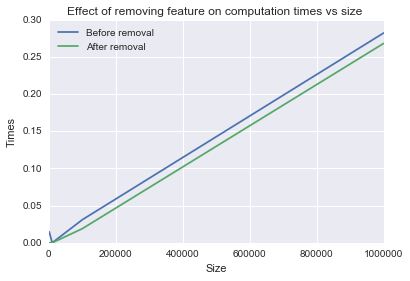

In [29]:
plt.plot(siz, times_before,label = "Before removal")

plt.plot(siz, times_after, label ="After removal")
plt.xlabel('Size')
plt.ylabel('Times')
plt.title('Effect of removing feature on computation times vs size ')
plt.legend(loc='upper left')

plt.show()

Our goal in this section is to try to figure out if what type of regression help better our predictions and if so when to use which regression. But let us recap the goal of Lasso, Rige and Elastic Net regression:




# Lasso Regression: 
"Short for least absolute shrinkage and selection operator (also Lasso or LASSO) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces." - Wikipedia

The key concept here to note is that it performs both feature selection and regularization. The cost function for lasso regression is similar to that of linear only we also additionally try to minimize the L1 / absolute sum of the coefficents as well. 

<p style="text-indent:25em;"> 
$Cost_{lasso} = Minimize  $$\sum_{i=1}^{n} \{ y_i - $$\sum_{j=0}^m w_j{x_i}_j $$ $$ \}  + \lambda $$\sum_{j=0}^m |w_j| $$ $
</p>

Hence intuitively we can see that 
<ol>
<li>
As the value of the regularization parameters increase, the coefficients tend to (or become ) zero.
</li>
<li>
If the regularization parameter is zero, the cost function is the same as that of linear regression.
</li>
</ol>

The convergence to a solution is obtained using gradient & coordinate descent.  

This may not intutively answer how the algorithm provides feature selection, to understand this component, we also need to understand the how the lasso regression algorithm converges to a solution. A rather simplistic explanation of the entire gradient descent process for this can be found here:

<ul>
<li>
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/
</li>
<li>
http://statweb.stanford.edu/~tibs/ftp/lassotalk.pdf
</li>
<li>
http://www.cs.cmu.edu/afs/cs/project/link-3/lafferty/www/ml-stat2/talks/YondaiKimGLasso-SLIDE-YD.pdf
</li>
</ul>

Since some L1 and L2 regularizers assume that the features are centered around zero, it is best to Standardize.

Source: http://scikit-learn.org/stable/modules/preprocessing.html

In [10]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(x_train)
X_TEST = StandardScaler().fit_transform(x_test)

lasso alpha: 0.01


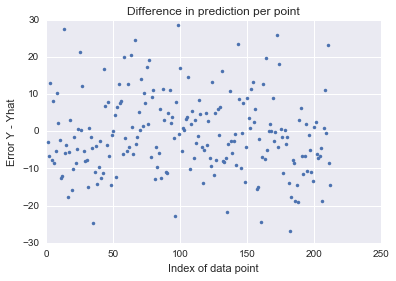

In [15]:
linearlasso = lr.LassoCV(alphas=[1e-4, 1e-1,1e-3,1e-2, 100], cv = 10 , normalize = True)
linearlasso.fit(X,y_train)
y_pred_lasso = linearlasso.predict(X_TEST)
print "lasso alpha:", linearlasso.alpha_ 
#compute mse
mselasso = np.mean(np.square(y_pred_lasso - y_test))
#store results
lasso_results = [mselasso, linearlasso.intercept_]
lasso_results.extend(linearlasso.coef_)
# lasso_results.append(0)
coef.loc['lasso'] = lasso_results
#plotting the difference in predictions against index
plt.plot(range(1,len(y_pred_lasso) + 1),y_test- y_pred_lasso,'.')
plt.xlabel("Index of data point")
plt.ylabel("Error Y - Yhat")
plt.title("Difference in prediction per point")


# Ridge Regression: 

This is very similar to lasso regression, only the cost function for ridge regression tries to minimize the L2 norm or  sum of squares of the coefficients. 

<p style="text-indent:25em;"> 
$Cost_{ridge} = Minimize  $$\sum_{i=1}^{n} \{ y_i - $$\sum_{j=0}^m w_j{x_i}_j $$ $$ \}  + \lambda $$\sum_{j=0}^m w_j^2 $$ $
</p>

Here 

$y_i$ = actual value of i element 

$ $$\sum_{j=0}^m w_j{x_i}_j $$ $ = the predicted value of i element 

$ \lambda$ = the regularization parameter (represented by alpha in below code) 

$ $$\sum_{j=0}^m w_j^2 $ = sum of squares of weights 

Hence intuitively we can see that 
<ol>
<li>
As the value of the regularization parameter increases, the coefficients tend to zero (do not become zero).
</li>
<li>
If the regularization parameter is zero, the cost function is the same as that of linear regression.
</li>
</ol>

The convergence to a solution is obtained using gradient & coordinate descent.  

<ul>
<li>
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/
</li>
<li>
http://statweb.stanford.edu/~tibs/ftp/lassotalk.pdf
</li>
<li>
http://www.cs.cmu.edu/afs/cs/project/link-3/lafferty/www/ml-stat2/talks/YondaiKimGLasso-SLIDE-YD.pdf
</li>
</ul>

ridge alpha: 0.1


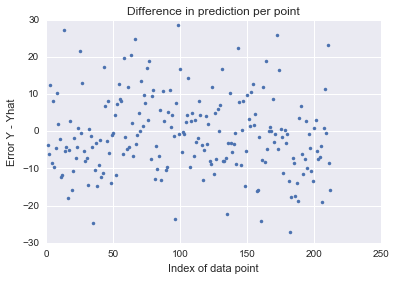

In [12]:
ridgelasso = lr.RidgeCV(alphas=[1e-4, 1e-1,1e-3,1e-2, 100], cv = 10, normalize=True)
ridgelasso.fit(X,y_train)
y_pred_ridge = ridgelasso.predict(X_TEST)
print "ridge alpha:",ridgelasso.alpha_
#compute mse
mseridge= np.mean(np.square(y_pred_ridge - y_test))
#storing results
ridge_result = [mseridge,ridgelasso.intercept_ ]
ridge_result.extend(ridgelasso.coef_)
# ridge_result.append(0)
coef.loc['ridge'] = ridge_result

plt.plot(range(1,len(y_pred_ridge) + 1),y_test- y_pred_ridge,'.')
plt.xlabel("Index of data point")
plt.ylabel("Error Y - Yhat")
plt.title("Difference in prediction per point")

# Elastic Net Regression
This is very similar to ridge and lasso regression except the cost function is a mixture of both L1 & L2.  
"The quadratic penalty term makes the loss function strictly convex, and it therefore has a unique minimum. The elastic net method includes the LASSO and ridge regression: in other words, each of them is a special case where ${\displaystyle \lambda _{1}=\lambda , \lambda _{2}=0} \lambda_1 = \lambda, \lambda_2 = 0$ or ${\displaystyle \lambda _{1}=0,\lambda _{2}=\lambda } \lambda_1 = 0, \lambda_2 = \lambda$." - Wikipedia

<p style="text-indent:25em;"> 
$Cost_{elastic} = Minimize  $$\sum_{i=1}^{n} \{ y_i - $$\sum_{j=0}^m w_j{x_i}_j $$ $$ \} + + \lambda_1 $$\sum_{j=0}^m |w_j| + \lambda_2 $$\sum_{j=0}^m w_j^2 $$ $
</p>

Here 

$y_i$ = actual value of i element 

$ $$\sum_{j=0}^m w_j{x_i}_j $$ $ = the predicted value of i element 

$ \lambda_1 , \lambda_2 $ = the regularization parameters (represented by alpha in below code) 

$ $$\sum_{j=0}^m w_j^2 $ = sum of squares of weights

$ $$\sum_{j=0}^m |w_j|$ = sum of absolute weights



elastic alpha: 0.001


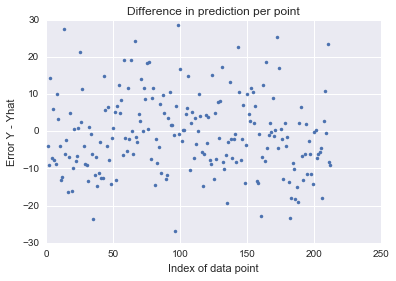

In [13]:
elastic = lr.ElasticNetCV(alphas=[1e-4,1e-1,1e-2,1e-3, 100],normalize= True, cv = 10)
elastic.fit(X,y_train)
y_pred_elastic = elastic.predict(X_TEST)
print "elastic alpha:", elastic.alpha_ 
#compute mse
mseelastic = np.mean(np.square(y_pred_elastic - y_test))
#storing results
elastic_result = [mseelastic,elastic.intercept_ ]
elastic_result.extend(elastic.coef_)
coef.loc['elastic'] = elastic_result
plt.plot(range(1,len(y_pred_elastic) + 1),y_test- y_pred_elastic,'.')
plt.xlabel("Index of data point")
plt.ylabel("Error Y - Yhat")
plt.title("Difference in prediction per point")

Let us now compare the coefficients from the two regressions:

In [14]:
coef

,mse,intercept,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,chd,famhist_Absent,weight
linear without weight,111.034,23.1426,0.0458969,0.801311,0.19222,1.30751,-0.0433297,-0.802898,0.0205214,2.93717,-2.07262,0
linear with weight,109.741,23.8532,0.0452067,0.798382,0.22231,1.30768,-0.0460369,7.7708,0.0215079,2.80172,-2.08676,-3.43687
lasso,109.502,43.26,0.771718,3.66587,0.309383,9.61076,-0.238859,-0,0.374157,1.36037,-0.885195,-3.00316
ridge,108.033,43.26,0.861822,3.73371,0.427862,9.95466,-0.418045,11.305,0.482075,1.38717,-1.0148,-14.7736
elastic,109.153,43.26,1.15505,3.50162,0.81075,7.59722,-0.450378,-0.853749,0.611391,1.54787,-0.975168,-0.986381


As we can see, in our scenario, ridge regression actually proved to be the better model. Some interesting observations are:
<ol>
<li>
Lasso regression assigned the coeffiecient of weight to be 0 on its own implying it performed variable selection. But, this need not imply that it would be the best model. 
</li>
<li>
Ridge regression peformed better than linear regression. This may be because as the alpha increases, this decreases variance with a slight increment in bias. Thus it is possible to achieve a better MSE. - Source https://rstudio-pubs-static.s3.amazonaws.com/22067_48fad02fb1a944e9a8fb1d56c55119ef.html#choosing-the-best-model . The drawback of ridge is that it assumes all features must be included in the model. 
</li>
<li>
Elastic Net's performance was in the middle of Ridge and Lasso.
</li>
</ol>

Note: You may be wondering about the effect of various values of alphas on the same case. The variation of alpha with error was already covered in class and more information can be found here:
http://scikit-learn.org/stable/modules/linear_model.html

For this exercise I just choose the alpha by performing a 10 fold CV on lasso against different alphas, selecting the best one for each model. 

Sources:
https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
http://statsmodels.sourceforge.net/0.6.0/examples/notebooks/generated/predict.html
https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb
http://blog.minitab.com/blog/understanding-statistics/handling-multicollinearity-in-regression-analysis
http://stackoverflow.com/questions/25676145/capturing-high-multi-collinearity-in-statsmodels
http://www.awesomestats.in/python-classification-sklearn-chd/